In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import os
import yaml
import torch
from audio_classification.tools import attack_model, attack_model_for_randomize_smoothing, attack_model_for_adv

torch.cuda.empty_cache()
#device = torch.device('cpu')
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
project_dir = '/nfs/students/winter-term-2020/project-1/'
save_folder = '/nfs/students/winter-term-2020/project-1/project-1/attack_results/adv'

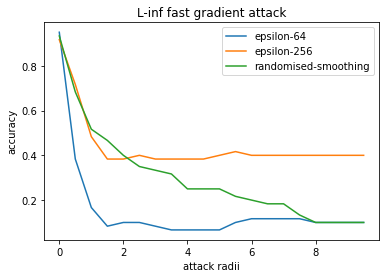

In [26]:
''' [sigma = 0.25 - 1, BMW Linf]
import matplotlib.pyplot as plt
y1 = [0.95, 0.3833333333333333, 0.16666666666666663, 0.08333333333333337, 0.09999999999999998, 0.09999999999999998, 0.08333333333333337, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.09999999999999998, 0.1166666666666667, 0.1166666666666667, 0.1166666666666667, 0.1166666666666667, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998]
y2 = [0.9166666666666666, 0.7166666666666667, 0.4833333333333333, 0.3833333333333333, 0.3833333333333333, 0.4, 0.3833333333333333, 0.3833333333333333, 0.3833333333333333, 0.3833333333333333, 0.4, 0.41666666666666663, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
y3 = [0.9333333333333333, 0.6833333333333333, 0.5166666666666666, 0.4666666666666667, 0.4, 0.35, 0.33333333333333337, 0.31666666666666665, 0.25, 0.25, 0.25, 0.21666666666666667, 0.19999999999999996, 0.18333333333333335, 0.18333333333333335, 0.1333333333333333, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998]
x = list(range(0, 10, 1)) + [i+0.5 for i in list(range(0, 10, 1))]
x.sort()
plt.plot(x, y1, label = "epsilon-64")
plt.plot(x, y2, label = "epsilon-256")
plt.plot(x, y3, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-inf fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

y1 = [0.9166666666666666, 0.4666666666666667, 0.2666666666666667, 0.23333333333333328, 0.23333333333333328, 0.16666666666666663, 0.1333333333333333, 0.1333333333333333, 0.1166666666666667, 0.1166666666666667, 0.1166666666666667, 0.08333333333333337, 0.08333333333333337, 0.08333333333333337, 0.08333333333333337, 0.08333333333333337, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.08333333333333337]
y2 = [0.9333333333333333, 0.5833333333333333, 0.3666666666666667, 0.33333333333333337, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.2833333333333333, 0.2833333333333333, 0.25, 0.23333333333333328, 0.21666666666666667, 0.16666666666666663, 0.15000000000000002, 0.1333333333333333, 0.09999999999999998, 0.08333333333333337, 0.08333333333333337, 0.06666666666666665, 0.06666666666666665]
y3 = [0.9, 0.65, 0.44999999999999996, 0.4, 0.3833333333333333, 0.3833333333333333, 0.3666666666666667, 0.35, 0.35, 0.35, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.30000000000000004, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2666666666666667]
x = list(range(0, 10, 1)) + [i+0.5 for i in list(range(0, 10, 1))]
x.sort()
plt.plot(x, y1, label = "epsilon-64")
plt.plot(x, y2, label = "epsilon-256")
plt.plot(x, y3, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-inf fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

y1 = [0.9333333333333333, 0.6166666666666667, 0.4833333333333333, 0.43333333333333335, 0.4, 0.35, 0.35, 0.35, 0.3666666666666667, 0.3666666666666667, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.31666666666666665, 0.33333333333333337, 0.35, 0.35, 0.35, 0.35, 0.35]
y2= [0.95, 0.8, 0.55, 0.44999999999999996, 0.4, 0.3833333333333333, 0.31666666666666665, 0.2666666666666667, 0.21666666666666667, 0.16666666666666663, 0.1333333333333333, 0.1166666666666667, 0.09999999999999998, 0.08333333333333337, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665]
y3 = [0.9833333333333333, 0.85, 0.5333333333333333, 0.3833333333333333, 0.2833333333333333, 0.2833333333333333, 0.23333333333333328, 0.21666666666666667, 0.21666666666666667, 0.18333333333333335, 0.16666666666666663, 0.16666666666666663, 0.15000000000000002, 0.15000000000000002, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.06666666666666665, 0.050000000000000044]
x = list(range(0, 10, 1)) + [i+0.5 for i in list(range(0, 10, 1))]
x.sort()
plt.plot(x, y1, label = "epsilon-64")
plt.plot(x, y2, label = "epsilon-256")
plt.plot(x, y3, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-inf fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
'''


{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tr

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3264.41 seconds
[0.74125, 0.6125, 0.485, 0.38125, 0.30874999999999997, 0.24250000000000005, 0.19625000000000004, 0.16000000000000003, 0.13875000000000004, 0.10124999999999995, 0.08750000000000002, 0.07874999999999999, 0.06625000000000003, 0.06625000000000003, 0.06125000000000003, 0.05625000000000002, 0.05500000000000005, 0.05249999999999999, 0.05125000000000002, 0.04874999999999996]


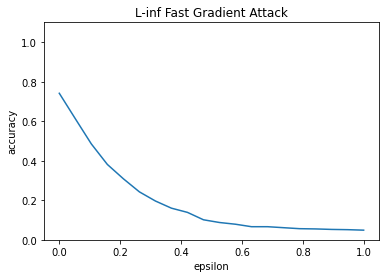

In [3]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-0.25-eps-256-epoch=31-val_acc=0.738.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tru

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3266.18 seconds
[0.72375, 0.60875, 0.48250000000000004, 0.35875, 0.27625, 0.22124999999999995, 0.16000000000000003, 0.13124999999999998, 0.10875000000000001, 0.09125000000000005, 0.0675, 0.057499999999999996, 0.053749999999999964, 0.05500000000000005, 0.04874999999999996, 0.03874999999999995, 0.036250000000000004, 0.026249999999999996, 0.030000000000000027, 0.02749999999999997]


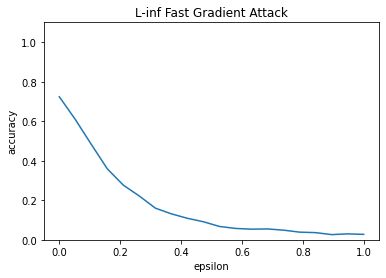

In [4]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-0.5-eps-256-epoch=46-val_acc=0.728.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': True}

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3270.11 seconds
[0.7475, 0.61625, 0.5625, 0.48750000000000004, 0.40874999999999995, 0.33875, 0.275, 0.21499999999999997, 0.16749999999999998, 0.13875000000000004, 0.125, 0.10124999999999995, 0.08750000000000002, 0.08250000000000002, 0.06625000000000003, 0.06499999999999995, 0.05500000000000005, 0.05874999999999997, 0.04749999999999999, 0.03874999999999995]


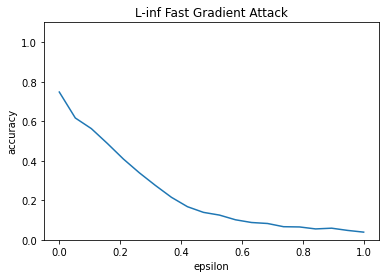

In [5]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-1.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-1-eps-256-epoch=116-val_acc=0.747.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/rs-us8k', 'NUM_GPUS': 1, 'MAX_EPOCH': 100, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/rs-us8k', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Tra

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 8168.23 seconds
[0.74875, 0.67625, 0.61375, 0.5587500000000001, 0.50625, 0.46499999999999997, 0.41000000000000003, 0.38125, 0.33999999999999997, 0.31625000000000003, 0.29000000000000004, 0.26125, 0.23750000000000004, 0.22624999999999995, 0.2025, 0.18625000000000003, 0.17000000000000004, 0.15500000000000003, 0.14249999999999996, 0.12875000000000003, 0.11750000000000005, 0.10375000000000001, 0.09750000000000003, 0.08750000000000002, 0.07499999999999996, 0.06374999999999997, 0.05625000000000002, 0.05125000000000002, 0.04500000000000004, 0.043749999999999956, 0.036250000000000004, 0.03374999999999995, 0.03125, 0.028750000000000053, 0.022499999999999964, 0.022499999999999964, 0.022499999999999964, 0.02124999999999999, 0.02124999999999999, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.018750000000000044, 0.016249999999999987, 0.01749999999999996, 0.01749999999999996, 0.01749999999999996, 0.015000000000000013, 0.0150000000000000

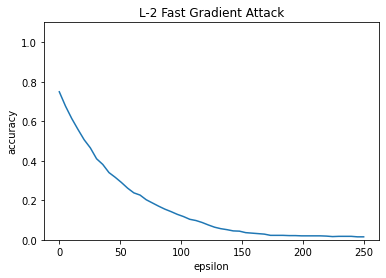

In [2]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-1-epoch=28-val_acc=0.767.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/rs-us8k', 'NUM_GPUS': 1, 'MAX_EPOCH': 100, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/rs-us8k', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Tra

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3277.28 seconds
[0.7475, 0.65125, 0.5449999999999999, 0.46499999999999997, 0.39125, 0.33999999999999997, 0.29625, 0.245, 0.20875, 0.17374999999999996, 0.14, 0.10999999999999999, 0.09125000000000005, 0.07874999999999999, 0.0675, 0.053749999999999964, 0.043749999999999956, 0.04125000000000001, 0.03749999999999998, 0.03249999999999997]


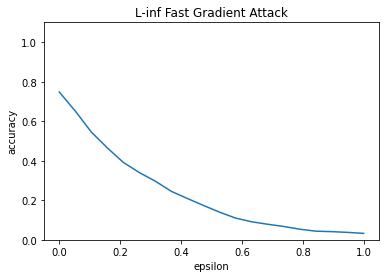

In [6]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-1-epoch=28-val_acc=0.767.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tr

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3276.20 seconds
[0.78375, 0.58125, 0.44999999999999996, 0.33125000000000004, 0.25625, 0.21125000000000005, 0.17874999999999996, 0.14875000000000005, 0.12250000000000005, 0.09999999999999998, 0.07750000000000001, 0.06625000000000003, 0.06000000000000005, 0.05249999999999999, 0.04749999999999999, 0.03874999999999995, 0.028750000000000053, 0.026249999999999996, 0.02124999999999999, 0.018750000000000044]


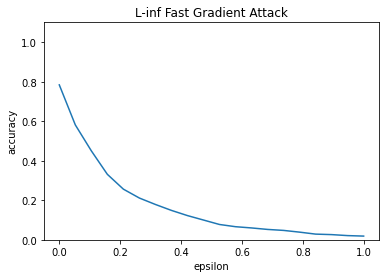

In [7]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25-rs.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-0.25-epoch=87-val_acc=0.768.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tru

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3270.03 seconds
[0.7262500000000001, 0.5900000000000001, 0.45875, 0.36124999999999996, 0.30374999999999996, 0.25875000000000004, 0.2025, 0.15625, 0.12749999999999995, 0.11624999999999996, 0.10124999999999995, 0.08875, 0.07499999999999996, 0.06499999999999995, 0.057499999999999996, 0.05125000000000002, 0.043749999999999956, 0.040000000000000036, 0.03249999999999997, 0.030000000000000027]


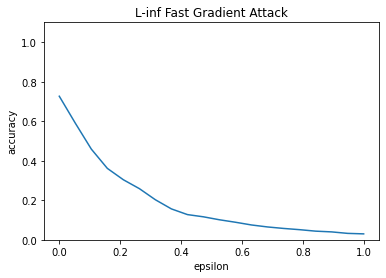

In [8]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5-rs.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-0.5-epoch=61-val_acc=0.763.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

In [ ]:
#run the two cells below

In [9]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25-rs.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-0.25-epoch=87-val_acc=0.768.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tr

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5-rs.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/rs-us8k/crnn-us8k-baseline-no-weight-smooth-0.5-epoch=61-val_acc=0.763.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

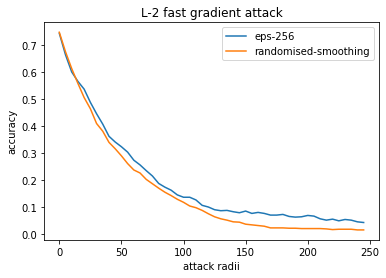

In [12]:
# Us8k L-2 results SmoothADV
y4 = [0.7375, 0.6725, 0.5875, 0.5137499999999999, 0.4425, 0.38625, 0.33999999999999997, 0.30000000000000004, 0.26875000000000004, 0.23750000000000004, 0.21750000000000003, 0.1875, 0.16249999999999998, 0.15125, 0.14125, 0.13749999999999996, 0.12624999999999997, 0.11375000000000002, 0.10124999999999995, 0.08875, 0.08250000000000002, 0.07625000000000004, 0.07250000000000001, 0.07125000000000004, 0.0675, 0.06125000000000003, 0.057499999999999996, 0.05125000000000002, 0.04749999999999999, 0.04749999999999999, 0.04874999999999996, 0.04625000000000001, 0.04625000000000001, 0.04125000000000001, 0.04249999999999998, 0.04125000000000001, 0.03749999999999998, 0.036250000000000004, 0.03500000000000003, 0.036250000000000004, 0.03374999999999995, 0.03249999999999997, 0.03125, 0.03249999999999997, 0.028750000000000053, 0.02749999999999997, 0.028750000000000053, 0.03125, 0.028750000000000053, 0.030000000000000027]
y5 = [0.7224999999999999, 0.64375, 0.585, 0.52625, 0.42125, 0.35750000000000004, 0.30500000000000005, 0.26875000000000004, 0.24124999999999996, 0.21499999999999997, 0.20125000000000004, 0.17000000000000004, 0.15625, 0.14625, 0.13624999999999998, 0.12375000000000003, 0.10624999999999996, 0.10624999999999996, 0.09624999999999995, 0.08750000000000002, 0.07499999999999996, 0.07250000000000001, 0.06874999999999998, 0.06125000000000003, 0.0625, 0.057499999999999996, 0.05625000000000002, 0.04625000000000001, 0.04249999999999998, 0.040000000000000036, 0.04249999999999998, 0.03874999999999995, 0.03749999999999998, 0.03500000000000003, 0.036250000000000004, 0.03500000000000003, 0.030000000000000027, 0.030000000000000027, 0.03125, 0.03125, 0.028750000000000053, 0.02749999999999997, 0.03125, 0.02375000000000005, 0.02375000000000005, 0.020000000000000018, 0.02749999999999997, 0.02749999999999997, 0.028750000000000053, 0.02749999999999997]
y6 = [0.745, 0.665, 0.6012500000000001, 0.5662499999999999, 0.5375, 0.48875, 0.44625000000000004, 0.4075, 0.36250000000000004, 0.34125000000000005, 0.32375, 0.30374999999999996, 0.27375000000000005, 0.25625, 0.235, 0.21499999999999997, 0.1875, 0.17374999999999996, 0.16249999999999998, 0.14500000000000002, 0.13624999999999998, 0.13624999999999998, 0.12624999999999997, 0.10624999999999996, 0.09999999999999998, 0.08999999999999997, 0.08625000000000005, 0.08750000000000002, 0.08250000000000002, 0.07874999999999999, 0.08499999999999996, 0.07625000000000004, 0.07999999999999996, 0.07625000000000004, 0.06999999999999995, 0.06999999999999995, 0.07250000000000001, 0.06499999999999995, 0.0625, 0.06374999999999997, 0.06874999999999998, 0.06625000000000003, 0.05625000000000002, 0.05125000000000002, 0.05500000000000005, 0.04874999999999996, 0.053749999999999964, 0.05125000000000002, 0.04500000000000004, 0.04249999999999998]
y7 = [0.74875, 0.67625, 0.61375, 0.5587500000000001, 0.50625, 0.46499999999999997, 0.41000000000000003, 0.38125, 0.33999999999999997, 0.31625000000000003, 0.29000000000000004, 0.26125, 0.23750000000000004, 0.22624999999999995, 0.2025, 0.18625000000000003, 0.17000000000000004, 0.15500000000000003, 0.14249999999999996, 0.12875000000000003, 0.11750000000000005, 0.10375000000000001, 0.09750000000000003, 0.08750000000000002, 0.07499999999999996, 0.06374999999999997, 0.05625000000000002, 0.05125000000000002, 0.04500000000000004, 0.043749999999999956, 0.036250000000000004, 0.03374999999999995, 0.03125, 0.028750000000000053, 0.022499999999999964, 0.022499999999999964, 0.022499999999999964, 0.02124999999999999, 0.02124999999999999, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.018750000000000044, 0.016249999999999987, 0.01749999999999996, 0.01749999999999996, 0.01749999999999996, 0.015000000000000013, 0.015000000000000013]
x = list(range(0, 250, 5)) #+ [i+0.5 for i in list(range(0, 10, 1))]
x.sort()
#plt.plot(x, y4, label = "sigma-0.25-256")
#plt.plot(x, y5, label = "sigma-0.5-256")
plt.plot(x, y6, label = "eps-256") 
plt.plot(x, y7, label = "randomised-smoothing")
#plt.plot(x, y8, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-2 fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

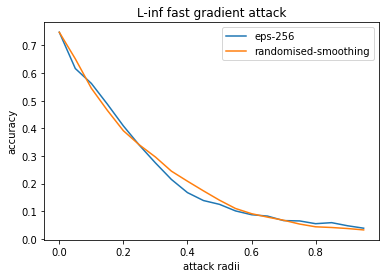

In [26]:
# Us8k L-inf results SmoothADV + rs
y1 = [0.74125, 0.6125, 0.485, 0.38125, 0.30874999999999997, 0.24250000000000005, 0.19625000000000004, 0.16000000000000003, 0.13875000000000004, 0.10124999999999995, 0.08750000000000002, 0.07874999999999999, 0.06625000000000003, 0.06625000000000003, 0.06125000000000003, 0.05625000000000002, 0.05500000000000005, 0.05249999999999999, 0.05125000000000002, 0.04874999999999996]
y2 = [0.72375, 0.60875, 0.48250000000000004, 0.35875, 0.27625, 0.22124999999999995, 0.16000000000000003, 0.13124999999999998, 0.10875000000000001, 0.09125000000000005, 0.0675, 0.057499999999999996, 0.053749999999999964, 0.05500000000000005, 0.04874999999999996, 0.03874999999999995, 0.036250000000000004, 0.026249999999999996, 0.030000000000000027, 0.02749999999999997]
y3 = [0.7475, 0.61625, 0.5625, 0.48750000000000004, 0.40874999999999995, 0.33875, 0.275, 0.21499999999999997, 0.16749999999999998, 0.13875000000000004, 0.125, 0.10124999999999995, 0.08750000000000002, 0.08250000000000002, 0.06625000000000003, 0.06499999999999995, 0.05500000000000005, 0.05874999999999997, 0.04749999999999999, 0.03874999999999995]
y4 = [0.78375, 0.58125, 0.44999999999999996, 0.33125000000000004, 0.25625, 0.21125000000000005, 0.17874999999999996, 0.14875000000000005, 0.12250000000000005, 0.09999999999999998, 0.07750000000000001, 0.06625000000000003, 0.06000000000000005, 0.05249999999999999, 0.04749999999999999, 0.03874999999999995, 0.028750000000000053, 0.026249999999999996, 0.02124999999999999, 0.018750000000000044]
y5 =  [0.7262500000000001, 0.5900000000000001, 0.45875, 0.36124999999999996, 0.30374999999999996, 0.25875000000000004, 0.2025, 0.15625, 0.12749999999999995, 0.11624999999999996, 0.10124999999999995, 0.08875, 0.07499999999999996, 0.06499999999999995, 0.057499999999999996, 0.05125000000000002, 0.043749999999999956, 0.040000000000000036, 0.03249999999999997, 0.030000000000000027]
y6 =  [0.7475, 0.65125, 0.5449999999999999, 0.46499999999999997, 0.39125, 0.33999999999999997, 0.29625, 0.245, 0.20875, 0.17374999999999996, 0.14, 0.10999999999999999, 0.09125000000000005, 0.07874999999999999, 0.0675, 0.053749999999999964, 0.043749999999999956, 0.04125000000000001, 0.03749999999999998, 0.03249999999999997]
x = [i/10 for i in list(range(0, 10, 1))  + [i+0.5 for i in list(range(0, 10, 1))]]
x.sort()
#plt.plot(x, y1, label = "sigma-0.25-256")
#plt.plot(x, y2, label = "sigma-0.5-256")
plt.plot(x, y3, label = "eps-256")
#plt.plot(x, y4, label = "0.25-rs") 
#plt.plot(x, y5, label = "0.5-rs")
plt.plot(x, y6, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-inf fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

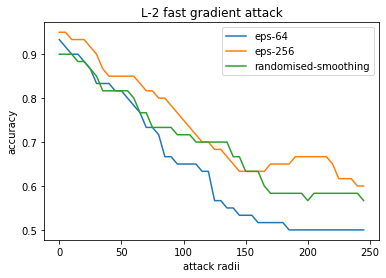

In [18]:
# BMW L-2 results SmoothADV
y1 = [0.95, 0.9333333333333333, 0.9166666666666666, 0.9, 0.8833333333333333, 0.8666666666666667, 0.8333333333333334, 0.8166666666666667, 0.7333333333333334, 0.6666666666666667, 0.6333333333333333, 0.6333333333333333, 0.6166666666666667, 0.5833333333333333, 0.5666666666666667, 0.55, 0.5333333333333333, 0.5333333333333333, 0.5, 0.4833333333333333, 0.4833333333333333, 0.4666666666666667, 0.41666666666666663, 0.4, 0.4, 0.4, 0.4, 0.3833333333333333, 0.3833333333333333, 0.35, 0.35, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2666666666666667, 0.2666666666666667, 0.2666666666666667, 0.2666666666666667, 0.2666666666666667, 0.2666666666666667, 0.2666666666666667, 0.25, 0.25, 0.25, 0.25, 0.25, 0.23333333333333328, 0.23333333333333328, 0.23333333333333328]
y2 = [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.85, 0.8333333333333334, 0.8166666666666667, 0.7833333333333333, 0.7833333333333333, 0.75, 0.75, 0.7333333333333334, 0.7166666666666667, 0.7, 0.6666666666666667, 0.6666666666666667, 0.65, 0.6333333333333333, 0.6333333333333333, 0.6166666666666667, 0.6, 0.5833333333333333, 0.5, 0.4833333333333333, 0.41666666666666663, 0.41666666666666663, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3833333333333333, 0.3833333333333333, 0.3833333333333333, 0.3833333333333333, 0.3666666666666667, 0.3666666666666667, 0.3666666666666667, 0.3666666666666667, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
y3 = [0.9333333333333333, 0.9166666666666666, 0.9, 0.9, 0.8833333333333333, 0.8666666666666667, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8166666666666667, 0.8166666666666667, 0.8, 0.7833333333333333, 0.7666666666666666, 0.7333333333333334, 0.7333333333333334, 0.7166666666666667, 0.6666666666666667, 0.6666666666666667, 0.65, 0.65, 0.65, 0.65, 0.6333333333333333, 0.6333333333333333, 0.5666666666666667, 0.5666666666666667, 0.55, 0.55, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5166666666666666, 0.5166666666666666, 0.5166666666666666, 0.5166666666666666, 0.5166666666666666, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
y4 = [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8833333333333333, 0.8833333333333333, 0.8666666666666667, 0.8333333333333334, 0.7833333333333333, 0.7666666666666666, 0.75, 0.75, 0.75, 0.7333333333333334, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7, 0.7, 0.7, 0.6833333333333333, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.65, 0.65, 0.65, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6166666666666667, 0.6166666666666667, 0.6166666666666667, 0.6166666666666667, 0.6166666666666667, 0.6166666666666667, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
y5 = [0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9, 0.9, 0.9, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8166666666666667, 0.7833333333333333, 0.7833333333333333, 0.7666666666666666, 0.7333333333333334, 0.7333333333333334, 0.7166666666666667, 0.7166666666666667, 0.7, 0.6833333333333333, 0.6166666666666667, 0.6, 0.5666666666666667, 0.5666666666666667, 0.5666666666666667, 0.55, 0.55, 0.55, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5166666666666666, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
y6 = [0.95, 0.95, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9166666666666666, 0.9, 0.8666666666666667, 0.85, 0.85, 0.85, 0.85, 0.85, 0.8333333333333334, 0.8166666666666667, 0.8166666666666667, 0.8, 0.8, 0.7833333333333333, 0.7666666666666666, 0.75, 0.7333333333333334, 0.7166666666666667, 0.7, 0.7, 0.6833333333333333, 0.6833333333333333, 0.6666666666666667, 0.65, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.65, 0.65, 0.65, 0.65, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.65, 0.6166666666666667, 0.6166666666666667, 0.6166666666666667, 0.6, 0.6]
y7 = [0.9333333333333333, 0.9, 0.9, 0.9, 0.8666666666666667, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8166666666666667, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.75, 0.7333333333333334, 0.7333333333333334, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7, 0.7, 0.6666666666666667, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333]
y8 = [0.9, 0.9, 0.9, 0.8833333333333333, 0.8833333333333333, 0.8666666666666667, 0.85, 0.8166666666666667, 0.8166666666666667, 0.8166666666666667, 0.8166666666666667, 0.8166666666666667, 0.8, 0.7666666666666666, 0.7666666666666666, 0.7333333333333334, 0.7333333333333334, 0.7333333333333334, 0.7333333333333334, 0.7166666666666667, 0.7166666666666667, 0.7166666666666667, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6666666666666667, 0.6666666666666667, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5666666666666667, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5833333333333333, 0.5666666666666667]
x = list(range(0, 250, 5)) #+ [i+0.5 for i in list(range(0, 10, 1))]
x.sort()
#plt.plot(x, y1, label = "sigma-0.25")
#plt.plot(x, y2, label = "sigma-0.5")
plt.plot(x, y3, label = "eps-64")
#plt.plot(x, y4, label = "sigma-0.25-256")
#plt.plot(x, y5, label = "sigma-0.5-256")
plt.plot(x, y6, label = "eps-256") #sigma= 1
#plt.plot(x, y7, label = "rs-0.25")
plt.plot(x, y8, label = "randomised-smoothing")
plt.xlabel('attack radii')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('L-2 fast gradient attack')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
## For Batch size = 3

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/us8k/', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Range of the input data is (-100.000000, 41.999760)
model device True


/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 233.96 seconds
tensor([0.9167, 0.1833, 0.0500, 0.0333, 0.0500, 0.1000, 0.2000, 0.2333, 0.2167,
        0.2333, 0.2500, 0.2667, 0.2667, 0.2833, 0.2833, 0.3167, 0.3500, 0.3667,
        0.4000, 0.4167], dtype=torch.float64)


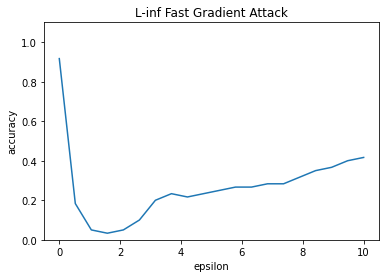

In [2]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 10
title = 'us8k_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=18-val_acc=0.667.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/us8k/', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Range of the input data is (-100.000000, 41.999760)
model device True


/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 234.57 seconds
tensor([0.9833, 0.0667, 0.0500, 0.0167, 0.0167, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
        0.0000, 0.0000], dtype=torch.float64)


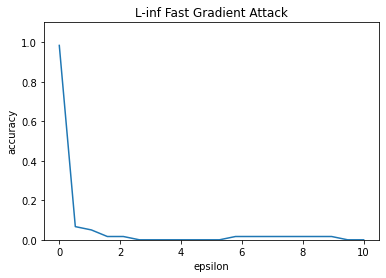

In [3]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 10
title = 'us8k_audio_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=31-val_acc=0.724.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/us8k/', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Range of the input data is (-100.000000, 41.999760)
model device True


/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 235.03 seconds
tensor([0.9667, 0.1500, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0167, 0.0167,
        0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], dtype=torch.float64)


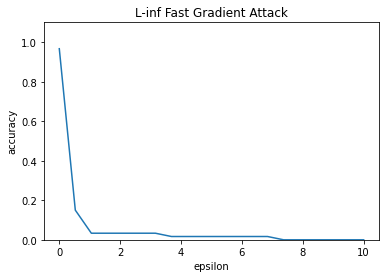

In [4]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 10
title = 'us8k_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=19-val_acc=0.708.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

In [ ]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=18-val_acc=0.667.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

In [ ]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_audio_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=31-val_acc=0.724.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

In [ ]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 250
title = 'us8k_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-us8k-epoch=19-val_acc=0.708.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 6, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'BMW', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'WEIGHT': 'NORMAL', 'VAL_FOLD': 1, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/'}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/bmw/', 'NUM_GPUS': 1, 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.001, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Data augmentation for BMW dataset: none
Range of the input data is (-82.704231, 41.936913)


/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 37350.23 seconds
tensor([0.9333, 0.6833, 0.5000, 0.4500, 0.3833, 0.3333, 0.3333, 0.2833, 0.2667,
        0.2333, 0.2500, 0.2167, 0.2167, 0.1667, 0.1500, 0.0833, 0.0833, 0.0833,
        0.0833, 0.0833], dtype=torch.float64)


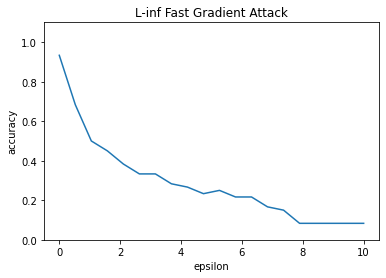

In [2]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 10
title = 'bmw_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-bmw-epoch=38-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 6, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'BMW', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'WEIGHT': 'NORMAL', 'VAL_FOLD': 1, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/'}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/bmw/', 'NUM_GPUS': 1, 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.001, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Data augmentation for BMW dataset: none
Range of the input data is (-82.704231, 41.936913)
model device 

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 41891.43 seconds
tensor([0.9000, 0.6167, 0.4333, 0.3833, 0.3833, 0.3667, 0.3667, 0.3333, 0.3333,
        0.3000, 0.2833, 0.2833, 0.2833, 0.2833, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500], dtype=torch.float64)


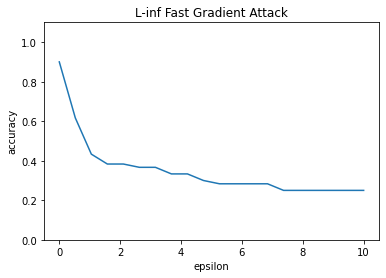

In [2]:
torch.cuda.empty_cache()
device = torch.device('cpu')
project="BMW"
max_rad = 10
title = 'bmw_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-bmw-epoch=42-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 6, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'BMW', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'WEIGHT': 'NORMAL', 'VAL_FOLD': 1, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/'}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/bmw/', 'NUM_GPUS': 1, 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.001, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Data augmentation for BMW dataset: none
Range of the input data is (-82.704231, 41.936913)
model device Fa

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 41593.95 seconds
tensor([0.9833, 0.8333, 0.5500, 0.4000, 0.2833, 0.2667, 0.2333, 0.2333, 0.2000,
        0.1833, 0.1667, 0.1500, 0.1333, 0.1000, 0.1000, 0.0667, 0.0667, 0.0667,
        0.0667, 0.0667], dtype=torch.float64)


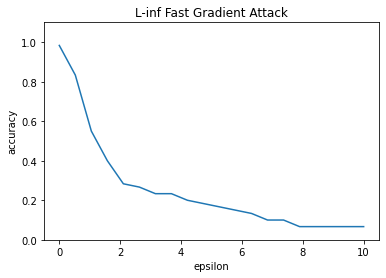

In [3]:
project="BMW"
max_rad = 10
title = 'bmw_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-bmw-epoch=24-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 6, 'CRNN': {'RANDOMISED_SMOOTHING': True, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False}}, 'DATASET': {'NAME': 'BMW', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'WEIGHT': 'NORMAL', 'VAL_FOLD': 1, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/'}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/bmw/', 'NUM_GPUS': 1, 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.001, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Data augmentation for BMW dataset: none
Range of the input data is (-82.704231, 41.936913)
model device 

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 98953.75 seconds
tensor([0.9000, 0.9000, 0.9000, 0.8833, 0.8833, 0.8667, 0.8500, 0.8500, 0.8167,
        0.8167, 0.8000, 0.7833, 0.7500, 0.7500, 0.7500, 0.7333, 0.7333, 0.7167,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.6833, 0.6833, 0.6500,
        0.6167, 0.6167, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
        0.5667, 0.5667, 0.5333, 0.5333, 0.5333, 0.5333, 0.5167, 0.5167, 0.5167,
        0.5000, 0.5000, 0.5000, 0.5000, 0.4833], dtype=torch.float64)


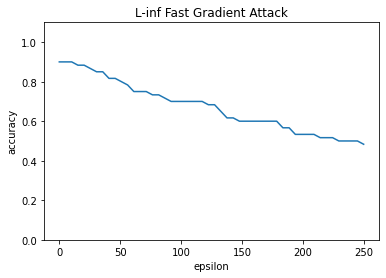

In [2]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 250
title = 'bmw_rs_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-bmw-epoch=42-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

In [ ]:
project="BMW"
max_rad = 250
title = 'bmw_rs_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/bmw/week-7/crnn-bmw-epoch=36-val_acc=1.000.ckpt'
attack_model(project_dir, config_path, pretrained_path, title, 
                                     project=project, max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 6, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'ATTACK': False}}, 'DATASET': {'NAME': 'BMW', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'WEIGHT': 'NORMAL', 'VAL_FOLD': 2, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/'}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/bmw/week-7', 'NUM_GPUS': 1, 'MAX_EPOCH': 50, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.001, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/bmw/week-7', 'SAVE_TOP_K': 1}, 'ATTACK': True}
Transformed raw audio into melspectrogram in dataloader.
Data augmentation for BMW dataset: none
Range of the input data is (-82.70423

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 0D cpu Long tensor

In [ ]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 250
title = 'bmw_rs_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/week-6/randomised-smoothing/crnn-bmw-epoch=38-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)